In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetLite0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np


# Set paths
data_dir = 'C:\\Toxic_Plants_Dataset_resized\\Toxic_Plants_Dataset_resized'

# Load data
batch_size = 32
img_height = 224
img_width = 224

In [59]:
# Split data into training, validation, and test sets
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = val_ds.take(len(val_ds) // 2)
val_ds = val_ds.skip(len(val_ds) // 2)

Found 6245 files belonging to 10 classes.
Using 4372 files for training.
Found 6245 files belonging to 10 classes.
Using 1873 files for validation.


In [60]:
class_names = train_ds.class_names

# Cache and prefetch the datasets for performance optimization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [61]:
# Define the model using EfficientNetLite0
num_classes = len(class_names)

base_model = EfficientLite0(input_shape=(img_height, img_width, 3),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 129s 861ms/step - accuracy: 0.4747 - loss: 1.6311 - val_accuracy: 0.7587 - val_loss: 0.8556
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 113s 829ms/step - accuracy: 0.7811 - loss: 0.7695 - val_accuracy: 0.8074 - val_loss: 0.6938
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 107s 784ms/step - accuracy: 0.8269 - loss: 0.6286 - val_accuracy: 0.8254 - val_loss: 0.6318
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 105s 765ms/step - accuracy: 0.8450 - loss: 0.5392 - val_accuracy: 0.8317 - val_loss: 0.5937
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 110s 807ms/step - accuracy: 0.8631 - loss: 0.4844 - val_accuracy: 0.8339 - val_loss: 0.5686
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 121s 882ms/step - accuracy: 0.8829 - loss: 0.4219 - val_accuracy: 0.8434 - val_loss: 0.5472
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 117s 853ms/step - accuracy: 0.8966 - loss: 0.3940 - val_accuracy: 0.8476 - val_loss: 0.5390
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 120s 877ms/step - accuracy: 0.8919 -

In [73]:
# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(train_ds)
print(f'Training accuracy: {train_acc}')
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f'Validation accuracy: {val_acc}')
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

137/137 ━━━━━━━━━━━━━━━━━━━━ 82s 598ms/step - accuracy: 0.9343 - loss: 0.2732
Training accuracy: 0.9325251579284668
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 572ms/step - accuracy: 0.8417 - loss: 0.4980
Validation accuracy: 0.8476190567016602
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 625ms/step - accuracy: 0.8468 - loss: 0.5037
Test accuracy: 0.857758641242981


In [66]:
# Get predictions and true labels for the test set
test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, pred_labels, target_names=class_names))
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 728ms/step
                    precision    recall  f1-score   support

     Angel Trumpet       0.78      0.85      0.82       101
       Castor Bean       0.86      0.84      0.85        73
            Cicuta       0.95      0.96      0.95        92
            Datura       0.78      0.80      0.79       125
       English Yew       0.90      0.93      0.91        95
          Foxglove       0.87      0.89      0.88       124
Lily of the Valley       0.90      0.87      0.89       107
        Manchineel       0.88      0.76      0.81        49
        Rosary Pea       0.87      0.72      0.79        36
   White Snakeroot       0.84      0.85      0.85       126

          accuracy                           0.86       928
         macro avg       0.86      0.85      0.85       928
      weighted avg       0.86      0.86      0.86       928

[[ 86   2   0  11   1   1   0   0   0   0]
 [  2  61   1   4   1   0   0   0   1   3]
 [  0   1  88   0   0   1   0

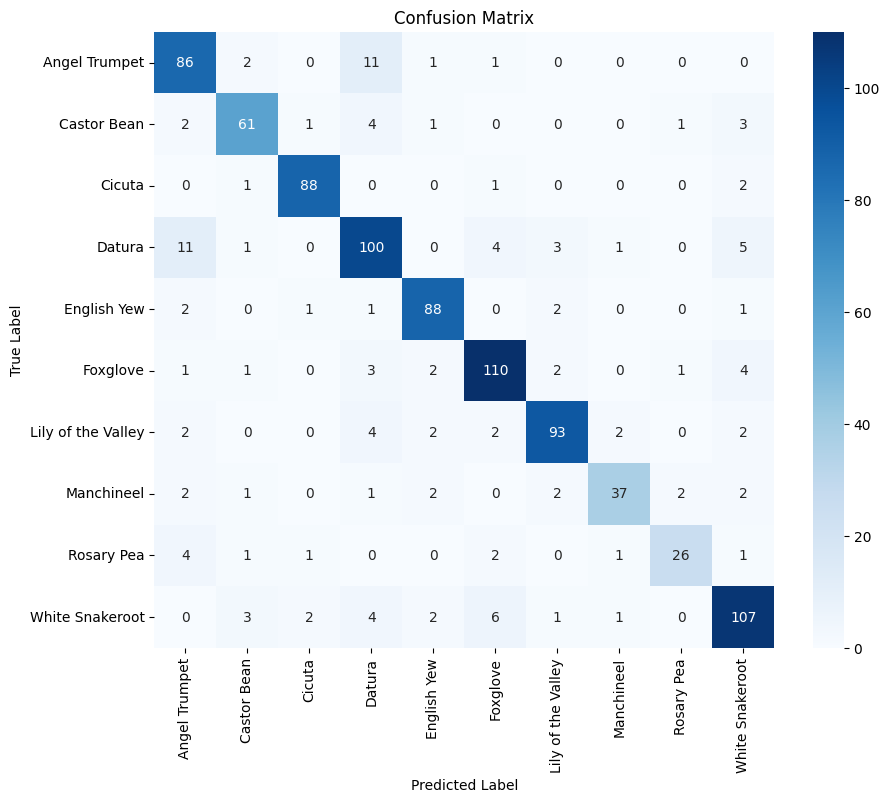

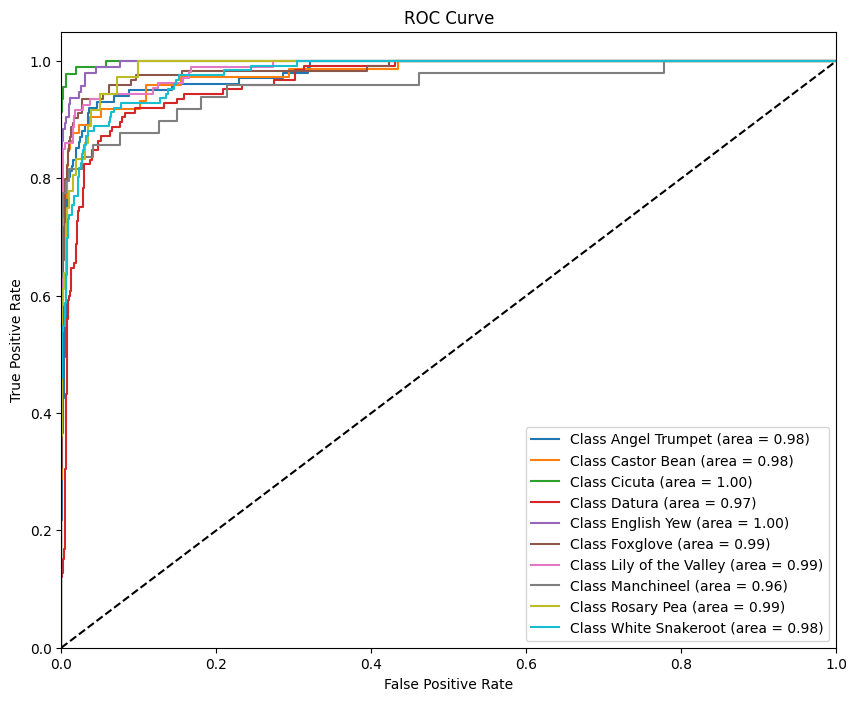

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_before.png')
plt.show()

# Plot ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_before.png')
plt.show()